In [1]:
from matplotlib import pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn import ensemble
from  sklearn import linear_model

import scipy.stats as stats
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy.stats import kurtosis, skew

from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
import math

%matplotlib inline

sns.set(rc={'figure.figsize':(12,7)}, style='whitegrid', color_codes=True)

Source = https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

This is a regression problem where we are trying to predict House prices based on various features.We also want to know some explanotory power of these features in determining the value of the houses.  Some algorithms that do well in predicting here are Random Forest Regression, Gradient Boost regression etc..

In [2]:
df = pd.read_csv('houses.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

######                     Data Cleaning              #######

In [4]:
df.isnull().sum()[df.isnull().sum() > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [5]:
# Alley, FireplaceQu, PoolQC, Fence since are not provided with any value we can categorize these
#as a new category'Not Available' or N_A

print (df.Alley.unique())
print (df.FireplaceQu.unique())
print (df.PoolQC.unique())
print (df.Fence.unique())
print (df.MiscFeature.unique())

df.Alley.fillna('N_A', inplace=True)
df.FireplaceQu.fillna('N_A', inplace=True)
df.PoolQC.fillna('N_A', inplace=True)
df.Fence.fillna('N_A', inplace=True)
df.MiscFeature.fillna('N_A', inplace=True)

# For Lot Frontage we can use the median values
df.LotFrontage.fillna(df.LotFrontage.median(), inplace=True)

[nan 'Grvl' 'Pave']
[nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']
[nan 'Ex' 'Fa' 'Gd']
[nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
[nan 'Shed' 'Gar2' 'Othr' 'TenC']


In [6]:
print (df.isnull().sum()[df.isnull().sum() > 0])
sum_nan=df.isnull().sum()[df.isnull().sum() > 0].sum()
n_obs_bef = df.shape[0]

MasVnrType       8
MasVnrArea       8
BsmtQual        37
BsmtCond        37
BsmtExposure    38
BsmtFinType1    37
BsmtFinType2    38
Electrical       1
GarageType      81
GarageYrBlt     81
GarageFinish    81
GarageQual      81
GarageCond      81
dtype: int64


These remaining null values can be dropped since they are small over the number of observations.

In [7]:
df.dropna(inplace=True, axis=0)
print ('Only %d rows dropped to remove a total of %d NaNs ' % (n_obs_bef-df.shape[0], sum_nan))
# Reset the index to avoid any errors later
df.reset_index(drop=True, inplace=True)

Only 122 rows dropped to remove a total of 609 NaNs 


In [8]:
# Dropping unnecessary variables in the analysis like Id
df.drop('Id', inplace=True, axis=1)

Before removing the outliers


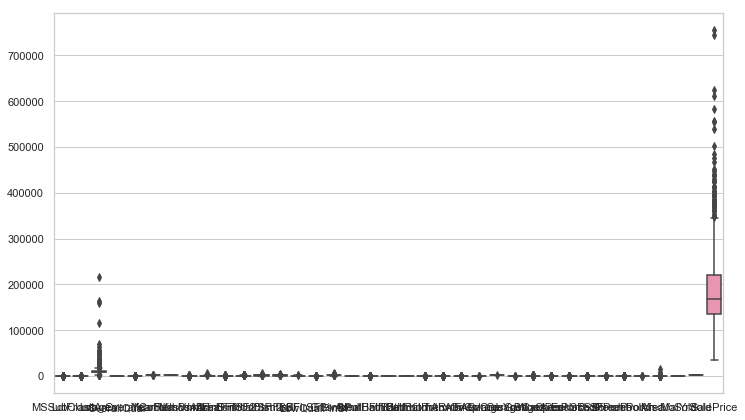

After removing the outliers


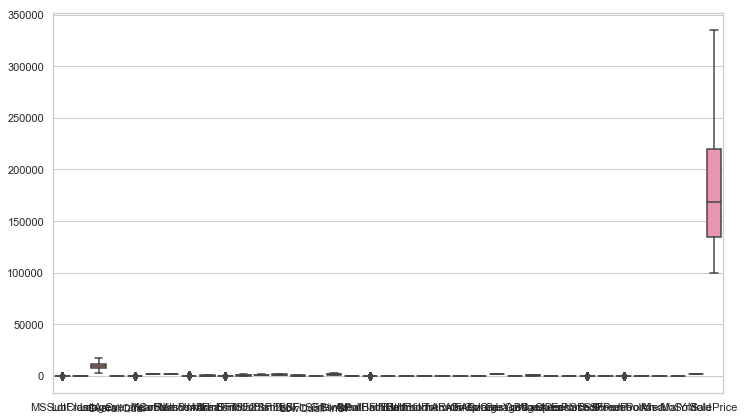

In [9]:
# Winsorising the outliers
sns.set(rc={'figure.figsize':(12,7)}, style='whitegrid', color_codes=True)
# Box plot before winsorizing
print ('Before removing the outliers')
g=sns.boxplot(data=df)
plt.show()

for columns in df:
    stats.mstats.winsorize(df[columns], inplace=True, limits = [0.05, 0.05])

# Box plot after winsorizing
print ('After removing the outliers')
g=sns.boxplot(data=df)
plt.show()

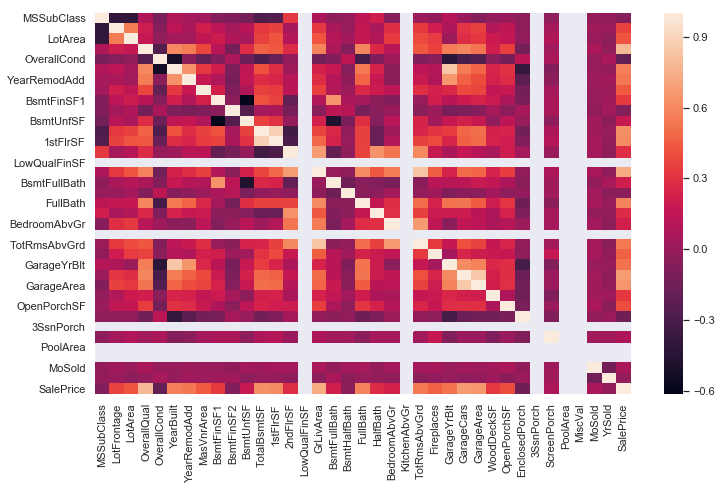

In [10]:
# Heat map
sns.set(rc={'figure.figsize':(12,7)})
sns.heatmap(df.corr())
plt.show()

From this correlation matrix we can see that except a few features rest have a positive correlation and add value to the house price.

We need to confirm this with 'feature selection method'. 'recursive feature elimination method' which acutally runs the model and sees which features have great explanatory power for the variance in the price.

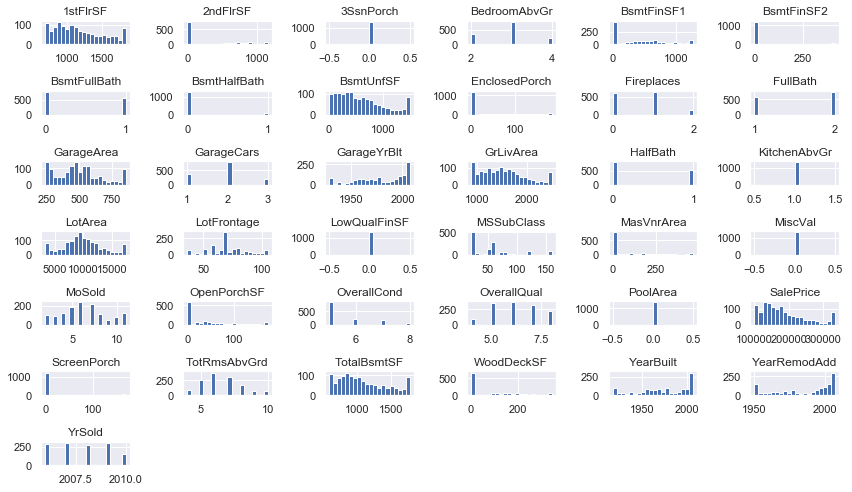

In [11]:
# Histogram plot to see the spread of the Variables
sns.set(rc={'figure.figsize':(12,7)})
num_datatype=df.select_dtypes(include=["number"])
num_datatype.hist(bins=20)
plt.tight_layout()
plt.show()

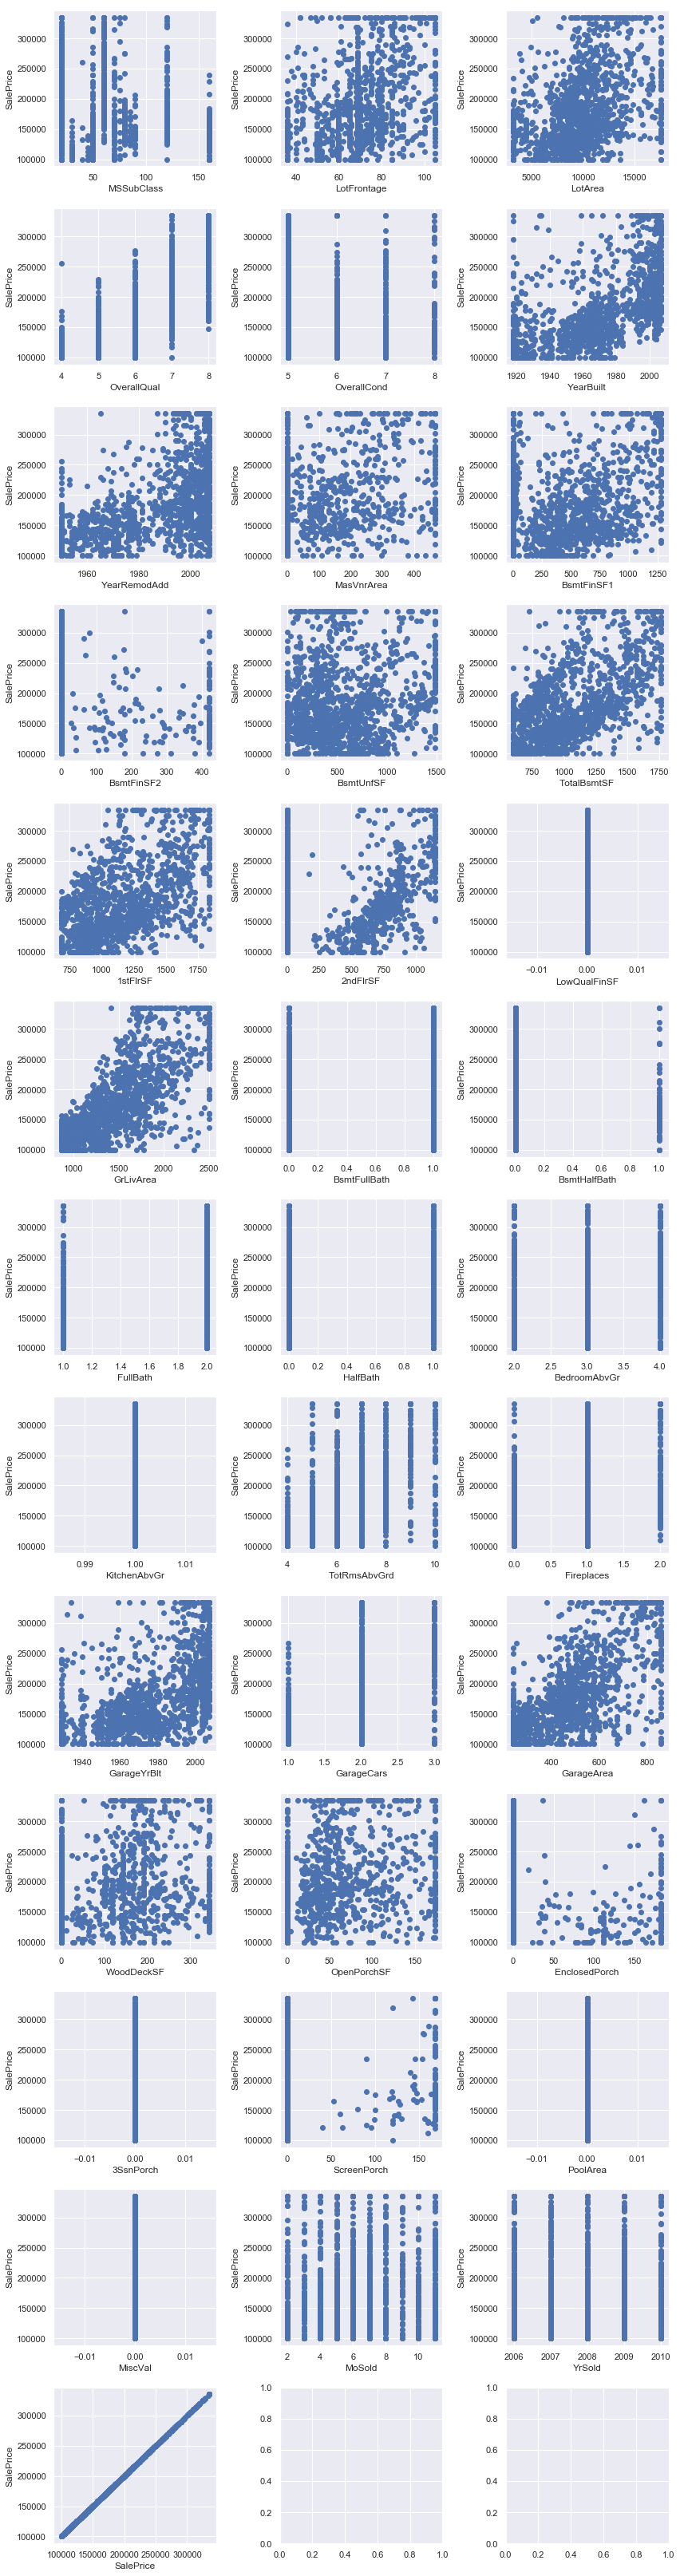

In [12]:
# Scatter plot to see the spread of the X variables in relation to outcome variable Y
num_datatype=df.select_dtypes(include=["number"])
x=y=0
fig, axes =plt.subplots(math.ceil(num_datatype.shape[1]/3),3)
fig.set_size_inches(12, 45)
for i in range(0, num_datatype.shape[1]):  
    axes[x,y].scatter(num_datatype.iloc[:, i], num_datatype['SalePrice'])
    axes[x,y].set(xlabel=num_datatype.columns[i], ylabel='SalePrice')
    plt.tight_layout()
    y+=1
    if (y==3):
        x+=1
        y=0
plt.show()

In [13]:
Y=df['SalePrice']
X=num_datatype.loc[:, ~(num_datatype.columns).isin(['SalePrice'])]

In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 36 columns):
MSSubClass       1338 non-null int64
LotFrontage      1338 non-null float64
LotArea          1338 non-null int64
OverallQual      1338 non-null int64
OverallCond      1338 non-null int64
YearBuilt        1338 non-null int64
YearRemodAdd     1338 non-null int64
MasVnrArea       1338 non-null float64
BsmtFinSF1       1338 non-null int64
BsmtFinSF2       1338 non-null int64
BsmtUnfSF        1338 non-null int64
TotalBsmtSF      1338 non-null int64
1stFlrSF         1338 non-null int64
2ndFlrSF         1338 non-null int64
LowQualFinSF     1338 non-null int64
GrLivArea        1338 non-null int64
BsmtFullBath     1338 non-null int64
BsmtHalfBath     1338 non-null int64
FullBath         1338 non-null int64
HalfBath         1338 non-null int64
BedroomAbvGr     1338 non-null int64
KitchenAbvGr     1338 non-null int64
TotRmsAbvGrd     1338 non-null int64
Fireplaces       1338 non-null int64
G

In [15]:
#### Using SelectKBest selector to select valued features

In [16]:
# feature extraction
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, Y)
# summarize scores and select the best 4 columns or features
np.set_printoptions(precision=3)
dic=dict()
for i, name in enumerate(X.columns):
    dic[name]=fit.scores_[i]
cols_selected=sorted(dic, key=dic.__getitem__, reverse=True)
print ('The most important columns are', cols_selected[0:4])

The most important columns are ['LotArea', '2ndFlrSF', 'BsmtFinSF1', 'BsmtUnfSF']


In [17]:
#### Using Recurssive Feature Elimination

In [18]:
#regr=linear_model.LogisticRegression(C=1e9, max_iter=300, solver='liblinear').fit(X,Y)
regr=linear_model.Lasso(alpha=0.001).fit(X,Y)
rfe = RFE(regr, 4)
fit = rfe.fit(X, Y)

dic=dict()
for i, name in enumerate(X.columns):
    dic[name]=fit.ranking_[i]
cols_selected=sorted(dic, key=dic.__getitem__)
print ('The most important columns are', cols_selected[0:4])

The most important columns are ['OverallQual', 'BsmtFullBath', 'Fireplaces', 'GarageCars']


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 80 columns):
MSSubClass       1338 non-null int64
MSZoning         1338 non-null object
LotFrontage      1338 non-null float64
LotArea          1338 non-null int64
Street           1338 non-null object
Alley            1338 non-null object
LotShape         1338 non-null object
LandContour      1338 non-null object
Utilities        1338 non-null object
LotConfig        1338 non-null object
LandSlope        1338 non-null object
Neighborhood     1338 non-null object
Condition1       1338 non-null object
Condition2       1338 non-null object
BldgType         1338 non-null object
HouseStyle       1338 non-null object
OverallQual      1338 non-null int64
OverallCond      1338 non-null int64
YearBuilt        1338 non-null int64
YearRemodAdd     1338 non-null int64
RoofStyle        1338 non-null object
RoofMatl         1338 non-null object
Exterior1st      1338 non-null object
Exterior2nd      1338 no

In [20]:
# Code that separates columns which have continous and discontinous data.
# The plan is to make dummy variables for only discontinous data.
conti_data=[]
disconti_data=[]
num_names=df.select_dtypes(include=['number']).columns.tolist()
for name in num_names:
    if len(df[name].unique()) > 100:
        conti_data.append(name)
    else:
        disconti_data.append(name)

In [21]:
# Creating Dummy variables for Categorical variables
categ_names=[]
object_names=df.select_dtypes(include=['object']).columns.tolist()
for name in object_names:
    categ_names.append(name)  
for name in disconti_data:
    categ_names.append(name) 
df_cat=pd.get_dummies(df[categ_names])
df.drop(categ_names, inplace=True, axis=1)
df.reset_index(drop=True, inplace=True)

In [22]:
# Including a feature for saleprice
# More features help in explaining the variance in the data and thus fit well
# and have less errors in prediction

df['SalePrice_high']=np.where(df['SalePrice'] > df['SalePrice'].quantile([0.75]).values[0], 1, 0)
df['SalePrice_avg']=np.where((df['SalePrice'] > df['SalePrice'].quantile([0.25]).values[0]) & (df['SalePrice'] < df['SalePrice'].quantile([0.75]).values[0]) , 1, 0)
df['SalePrice_low']=np.where(df['SalePrice'] < df['SalePrice'].quantile([0.25]).values[0], 1, 0)
df['SalePrice'].describe()

count      1338.000000
mean     183538.828102
std       64158.957633
min      100000.000000
25%      135000.000000
50%      168500.000000
75%      220000.000000
max      335000.000000
Name: SalePrice, dtype: float64

In [23]:
# Scaling the data
num_names=df.select_dtypes(include=['number'], exclude=['bool']).columns.tolist()
df1=pd.DataFrame(preprocessing.scale(df[num_names]), columns=num_names)
bina_name=['SalePrice_high', 'SalePrice_avg','SalePrice_low' ]

for name in bina_name:
    df1[name]=df[name]
    
for name in df_cat.columns:
    df1[name]= pd.Series(df_cat[name].tolist())
df1.info()

C:\Users\nagad\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Columns: 202 entries, LotArea to SaleCondition_Partial
dtypes: float64(14), int32(3), int64(185)
memory usage: 2.0 MB


In [24]:
Y=df1['SalePrice']
X=df1.loc[:, ~(df1.columns).isin(['SalePrice'])]

In [25]:
X.head()

,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,WoodDeckSF,...,MiscFeature_N_A,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.387985,0.671933,0.617406,-1.021487,-0.681347,-0.928150,1.205985,0.420852,0.291692,-0.842156,...,1,0,0,1,0,0,0,0,1,0
1,-0.059093,-0.683323,1.276372,-0.697206,0.531006,0.290680,-0.829755,-0.577209,-0.221678,1.827106,...,1,0,0,1,0,0,0,0,1,0
2,0.412796,0.436838,0.084419,-0.334205,-0.490237,-0.736019,1.234590,0.590166,0.641718,-0.842156,...,1,0,0,1,0,0,0,0,1,0
3,-0.073393,-0.683323,-0.569702,-0.077684,-0.979956,-0.612935,0.972375,0.436447,0.840066,-0.842156,...,1,0,0,1,1,0,0,0,0,0
4,1.273636,1.736778,0.493850,-0.198685,0.181634,-0.060559,1.680355,1.508025,1.971815,0.877637,...,1,0,0,1,0,0,0,0,1,0


In [26]:
# Functions for easy screening of models
def model(mod,X, Y):
    #Data split to Train and test
    global X_train, X_test, y_train, y_test
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=1)
    model_object=mod
    model_object.fit(X_train, y_train)
    evaluation_continuous(model_object)
    return model_object

def evaluation_continuous(model_object):
    #Evalution of model
    score=cross_val_score(X=X_test, y=y_test, estimator=model_object, cv=10)
    print("\nAccuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
    
    # Calculate the error, also called the residual.
    
    actual=y_test
    predicted=model_object.predict(X_test)
    residual = actual - predicted
    print ('\nThe Root Mean Squared Error is %0.2f'%np.sqrt(mean_squared_error(actual, predicted)))
    plt.scatter(predicted, residual)
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.axhline(y=0)
    plt.title('Residual vs. Predicted')
    plt.show()
    
    plt.hist(residual, bins=40)
    plt.title('Residual counts')
    plt.xlabel('Residual')
    plt.ylabel('Count')
    plt.show()
    return

### Random Forest Regression

C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Accuracy: 0.93 (+/- 0.05)

The Root Mean Squared Error is 0.23


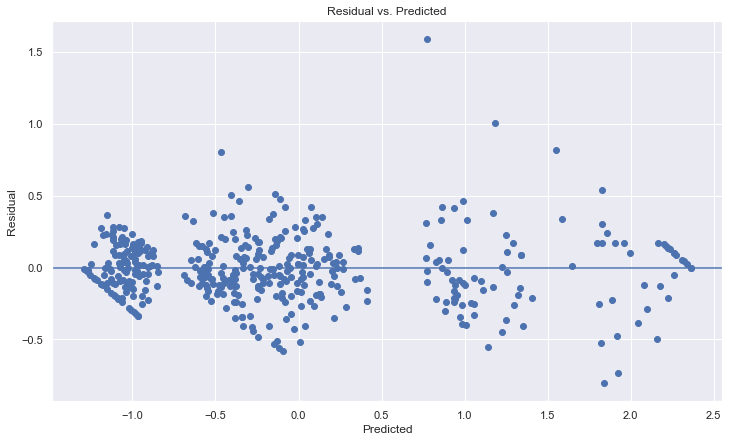

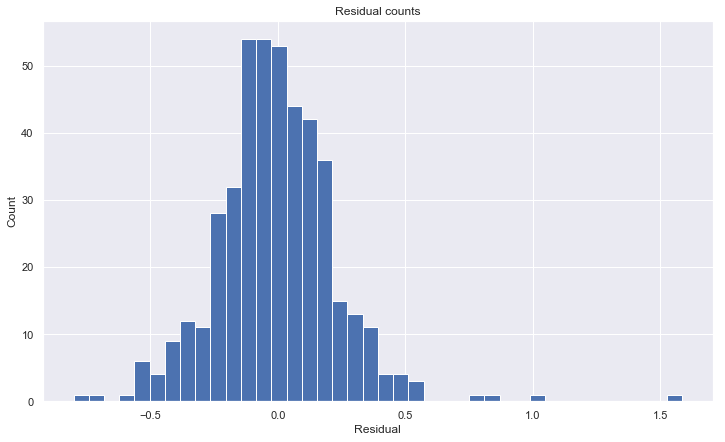

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [27]:
model(ensemble.RandomForestRegressor(), X, Y)

The residual plot appears to do well expect that very high/low values are not predicted very well with this model.

The residual histogram plot shows if there is multivariate normality of the error. The outlier or skewness in error must be fixed for better performance.

### Ridge Regression


Accuracy: 0.90 (+/- 0.07)

The Root Mean Squared Error is 0.31


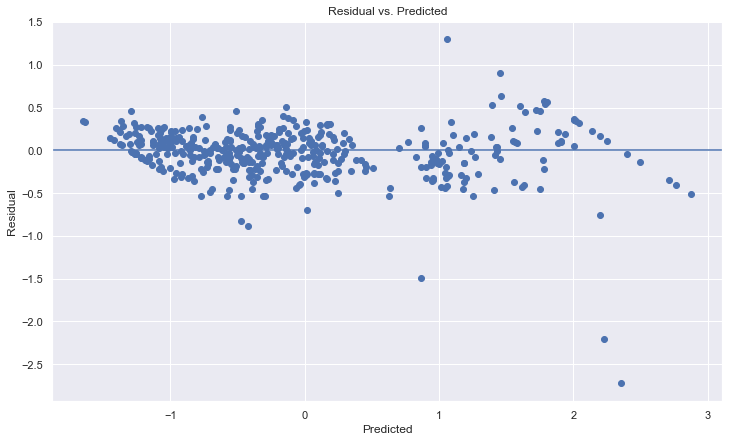

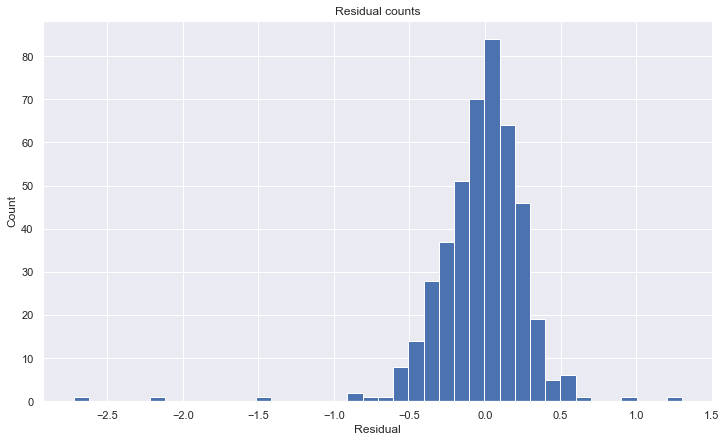

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [28]:
model(linear_model.Ridge(), X, Y)


### Lasso Regression


Accuracy: 0.91 (+/- 0.06)

The Root Mean Squared Error is 0.29


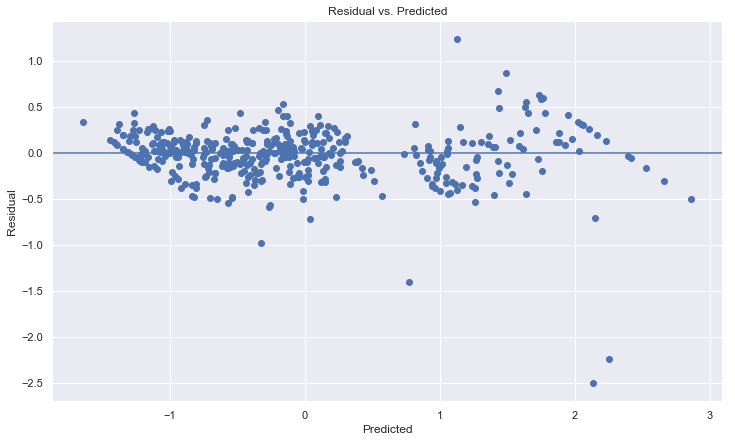

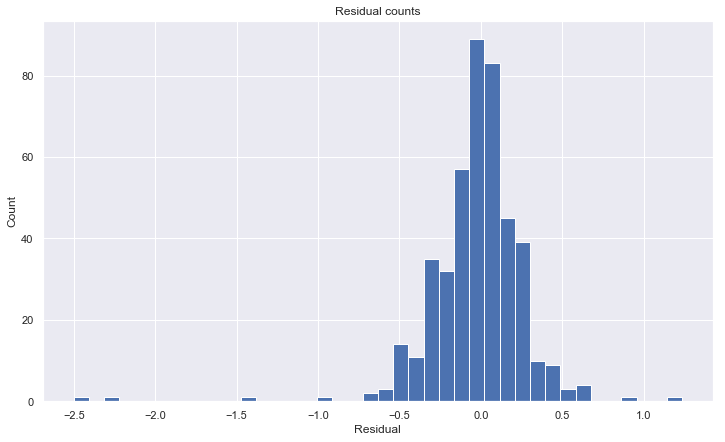

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [29]:
model(linear_model.Lasso(alpha=0.001), X, Y)

### Gradient Boost Regression


Accuracy: 0.92 (+/- 0.06)

The Root Mean Squared Error is 0.26


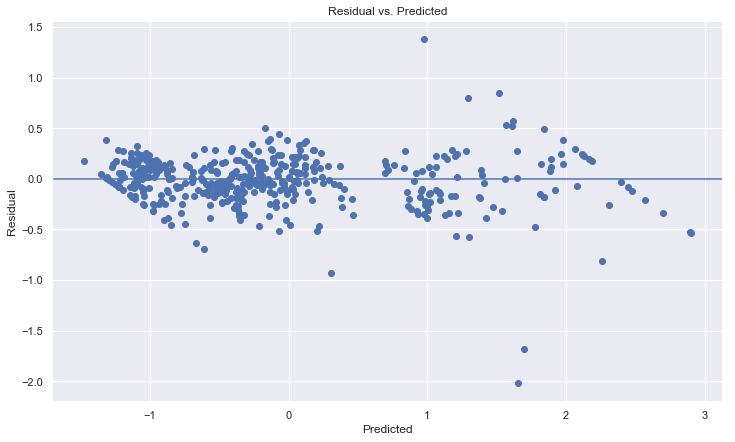

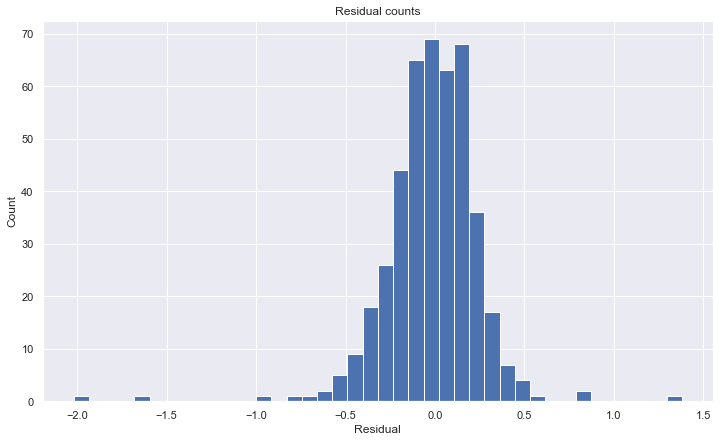

In [30]:
params = {'n_estimators': 500,
          'max_depth': 2}
model(ensemble.GradientBoostingRegressor(**params), X, Y)
plt.show()



Accuracy: 0.92 (+/- 0.06)

The Root Mean Squared Error is 0.26


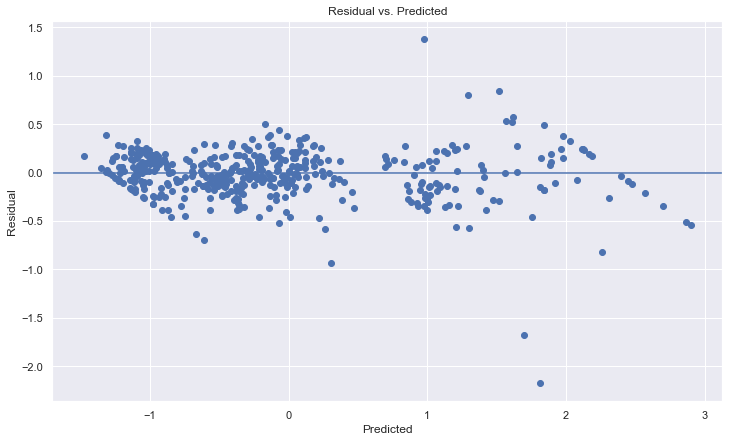

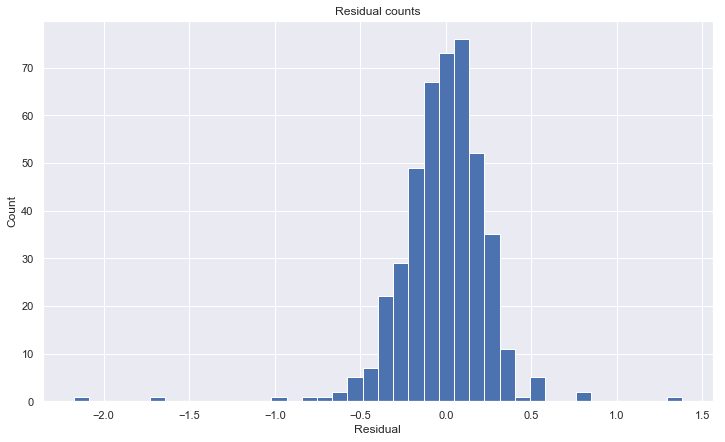

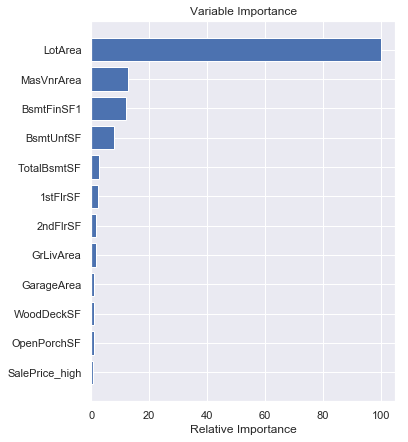

In [31]:
mo=model(ensemble.GradientBoostingRegressor(**params), X, Y)
feature_importance = mo.feature_importances_
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
fea_imp=np.array(sorted(list(feature_importance), reverse=True)[0:12])
sorted_idx = np.argsort(fea_imp)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, fea_imp[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

As suggested by the Gradient boost model above are the top 12 features needed for a real estate developer to add value to a house and also predictive of the prices of house.

Random Forest Regression has the highest accuracy of 93%  and Random Forest Regression model has the next highest with 92% accuracy

In terms of the lowest error Random Forest Regression model has the lowest error compared to all other models.